Donya Razinejad, Spring 2024

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# inventory_df = pd.read_excel('Proceco_IM (1).xlsx')

In [3]:
suppliers_kpis_df = pd.read_excel('Suppliers_KPIs_.xlsx')

In [4]:
# logistic_df = pd.read_excel('Proceco_MOS (1).xlsx')

In [5]:
suppliers_kpis_df.head()

,MOS_OLPHKEY,MOS_OLREFNO,PH_BUYER,PH_VNKEY,VN_NAME,MOS_IMKEY,IM_DESCR,RELEASE_DATE_PO,DUE_DATE,PROMISE_DATE,DATE_RECEIVED,QTY_ORDER,QTY_RECEIVED,OL_UNIT_R,UNIT_PRICE,PO_PRICE,Fiscal period,BACKORDER_DAYS_LATE,LEAD TIME
0,STE22520,2,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA060A,3/4 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,2022-01-03,100,100,FT,5.1740,517.40,2022-01-01,16.0,24
1,STE22590,9,SPERRON,L175,LUMEN INC.,X21503L04,VARIATEUR 0.5HP-575V,2021-12-06,2022-01-11,2022-01-11,2022-01-03,1,1,EA,1131.3900,1131.39,2022-01-01,NaN,20
2,DIM22843,1,DSOKOLOV,C650,13859380 CANADA INC.,NEA240A,"3"" TUYAU SS304L SCH 40",2021-12-22,2022-01-05,2022-01-05,2022-01-03,240,240,FT,34.1190,8188.56,2022-01-01,NaN,8
3,DIM22761,6,DSOKOLOV,C103,C.F.F. SPECIALTY METALS INC.,NIA060A,"3/4"" TUYAU, SS316L,SCH 40.",2021-12-16,2022-01-20,2022-01-20,2022-01-03,480,480,FT,5.3000,2544.00,2022-01-01,NaN,12
4,STE22520,1,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA040A,1/2 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,2022-01-03,200,200,FT,4.8825,976.50,2022-01-01,16.0,24


In [6]:
suppliers_kpis_df['BACKORDER_DAYS_LATE'] = suppliers_kpis_df['BACKORDER_DAYS_LATE'].fillna(0)

In [7]:
print(suppliers_kpis_df.columns)

Index(['MOS_OLPHKEY', 'MOS_OLREFNO', 'PH_BUYER', 'PH_VNKEY', 'VN_NAME',
       'MOS_IMKEY', 'IM_DESCR', 'RELEASE_DATE_PO', 'DUE_DATE', 'PROMISE_DATE',
       'DATE_RECEIVED', 'QTY_ORDER', 'QTY_RECEIVED', 'OL_UNIT_R', 'UNIT_PRICE',
       'PO_PRICE', 'Fiscal period', 'BACKORDER_DAYS_LATE', 'LEAD TIME'],
      dtype='object')


In [8]:
# Convert date columns from string to datetime if they're not already in datetime format
date_columns = ['RELEASE_DATE_PO', 'PROMISE_DATE', 'DATE_RECEIVED','DUE_DATE']
for column in date_columns:
    suppliers_kpis_df[column] = pd.to_datetime(suppliers_kpis_df[column])

# Calculate 'Lead Time' and 'Late Arrival' and add them to the suppliers_kpis_df DataFrame
suppliers_kpis_df['Late_or_Early_Arrival'] = (suppliers_kpis_df['DATE_RECEIVED'] - suppliers_kpis_df['PROMISE_DATE']).dt.days

# Now, suppliers_kpis_df contains the new columns


In [9]:
suppliers_kpis_df

,MOS_OLPHKEY,MOS_OLREFNO,PH_BUYER,PH_VNKEY,VN_NAME,MOS_IMKEY,IM_DESCR,RELEASE_DATE_PO,DUE_DATE,PROMISE_DATE,DATE_RECEIVED,QTY_ORDER,QTY_RECEIVED,OL_UNIT_R,UNIT_PRICE,PO_PRICE,Fiscal period,BACKORDER_DAYS_LATE,LEAD TIME,Late_or_Early_Arrival
0,STE22520,2,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA060A,3/4 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,2022-01-03,100,100,FT,5.1740,517.40,2022-01-01,16.0,24,24
1,STE22590,9,SPERRON,L175,LUMEN INC.,X21503L04,VARIATEUR 0.5HP-575V,2021-12-06,2022-01-11,2022-01-11,2022-01-03,1,1,EA,1131.3900,1131.39,2022-01-01,0.0,20,-8
2,DIM22843,1,DSOKOLOV,C650,13859380 CANADA INC.,NEA240A,"3"" TUYAU SS304L SCH 40",2021-12-22,2022-01-05,2022-01-05,2022-01-03,240,240,FT,34.1190,8188.56,2022-01-01,0.0,8,-2
3,DIM22761,6,DSOKOLOV,C103,C.F.F. SPECIALTY METALS INC.,NIA060A,"3/4"" TUYAU, SS316L,SCH 40.",2021-12-16,2022-01-20,2022-01-20,2022-01-03,480,480,FT,5.3000,2544.00,2022-01-01,0.0,12,-17
4,STE22520,1,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA040A,1/2 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,2022-01-03,200,200,FT,4.8825,976.50,2022-01-01,16.0,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22346,STE29501,1,SPERRON,K073,WAJAX LTEE.,EAU028A,O-RING 1.109DI X 0.139 NITRILE,2023-10-24,2023-11-01,2023-11-01,2023-10-25,2,2,EA,0.0600,0.12,2023-10-01,0.0,1,-7
22347,ERI29479,5,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIQ600A,TOLE SS304L CR 20GA 2B+PLASTIC,2023-10-23,2023-10-25,2023-10-25,2023-10-25,50447,50447,LB,2.1100,106443.17,2023-10-01,0.0,2,0
22348,ERI29479,8,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIP050A,"PLAQUE HR 3/16, SS304L",2023-10-23,2023-10-25,2023-10-25,2023-10-25,14401,14401,LB,2.0100,28946.01,2023-10-01,0.0,2,0
22349,ERI29479,1,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIF075A,BARRE PLATE SS304L HR 1/8x1,2023-10-23,2023-10-25,2023-10-25,2023-10-25,306,279,LB,2.9500,902.70,2023-10-01,0.0,2,0


In [10]:
# List of numerical columns to scale
numerical_cols = ['UNIT_PRICE', 'BACKORDER_DAYS_LATE', 'LEAD TIME', 'Late_or_Early_Arrival']

# Scaling the numerical columns
scaler = StandardScaler()
suppliers_kpis_df[numerical_cols] = scaler.fit_transform(suppliers_kpis_df[numerical_cols])

# Filtering out rows with any scaled value > 3 or < -3
suppliers_kpis_df = suppliers_kpis_df[(suppliers_kpis_df[numerical_cols] <= 3).all(axis=1) & (suppliers_kpis_df[numerical_cols] >= -3).all(axis=1)]


In [11]:
# Aggregating supplier data
supplier_aggregated = suppliers_kpis_df.groupby('VN_NAME').agg({
    'UNIT_PRICE': 'mean',
    'BACKORDER_DAYS_LATE': 'mean',
    "LEAD TIME": 'mean',
}).reset_index()

# Feature Scaling
scaled_features = scaler.fit_transform(supplier_aggregated.iloc[:, 1:])

# Clustering using K-Means with k=5 and fixed random_state
kmeans = KMeans(n_clusters=5, random_state=23)  # Fixing random_state for reproducibility
supplier_aggregated['Supplier_cluster'] = kmeans.fit_predict(scaled_features)

# Merging cluster labels back with the original data
suppliers_with_clusters = pd.merge(suppliers_kpis_df, supplier_aggregated[['VN_NAME', 'Supplier_cluster']], on='VN_NAME', how='left')

C:\Users\15146\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\15146\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


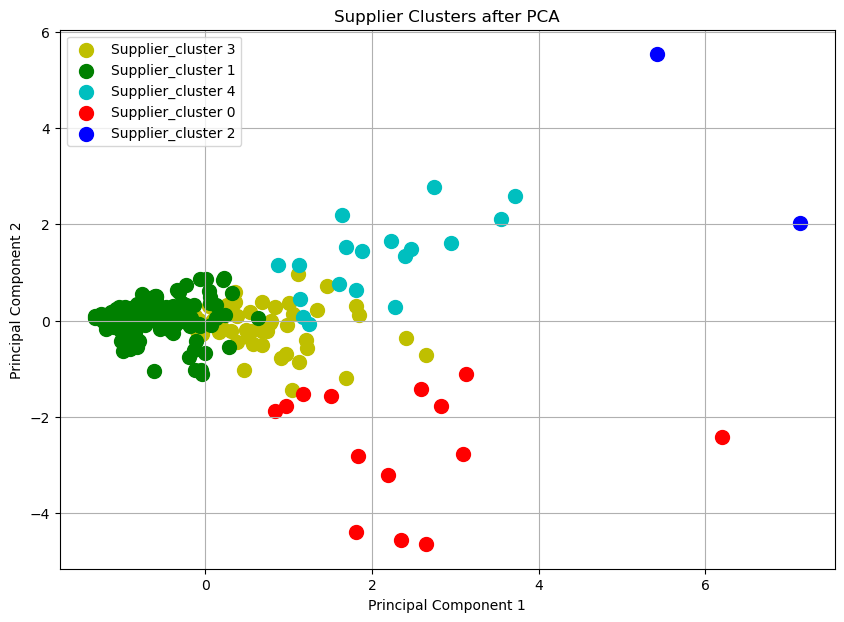

In [12]:
# Reducing the dimensionality for visualization
pca = PCA(n_components=2)  # Reduce to 2 dimensions for a 2D plot
principal_components = pca.fit_transform(scaled_features)

# Create a new DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Supplier_cluster'] = supplier_aggregated['Supplier_cluster']

# Plotting
plt.figure(figsize=(10, 7))
plt.title('Supplier Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Color each cluster
colors = ['r', 'g', 'b', 'y', 'c', 'm']  # Extend this list for more clusters if needed
for cluster in pca_df['Supplier_cluster'].unique():
    cluster_subset = pca_df[pca_df['Supplier_cluster'] == cluster]
    plt.scatter(cluster_subset['Principal Component 1'], cluster_subset['Principal Component 2'], s=100, label=f'Supplier_cluster {cluster}', color=colors[cluster])

plt.legend()
plt.grid(True)
plt.show()

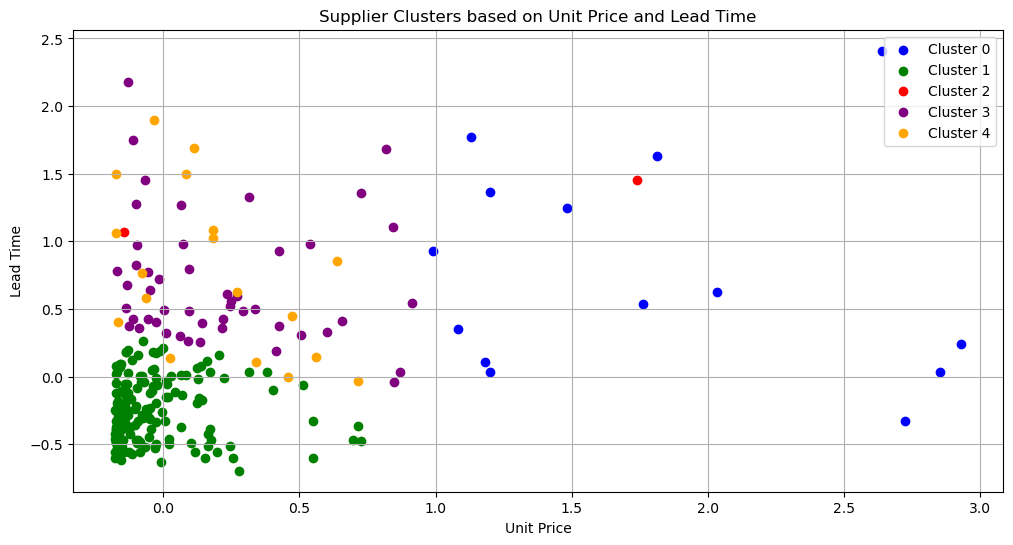

In [13]:
import matplotlib.pyplot as plt

# Scatter plot of the clusters
plt.figure(figsize=(12, 6))

# Define colors for clusters
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Add more colors if needed

# Iterate over unique cluster labels
for cluster_label, color in zip(range(5), colors):
    cluster_data = supplier_aggregated[supplier_aggregated['Supplier_cluster'] == cluster_label]
    plt.scatter(cluster_data['UNIT_PRICE'], cluster_data['LEAD TIME'], label=f'Cluster {cluster_label}', color=color)

# Adding labels and legend
plt.xlabel('Unit Price')
plt.ylabel('Lead Time')
plt.title('Supplier Clusters based on Unit Price and Lead Time')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [14]:
suppliers_kpis_df = pd.merge(suppliers_kpis_df, supplier_aggregated[['VN_NAME', 'Supplier_cluster']], on='VN_NAME', how='left')

In [15]:
suppliers_kpis_df

,MOS_OLPHKEY,MOS_OLREFNO,PH_BUYER,PH_VNKEY,VN_NAME,MOS_IMKEY,IM_DESCR,RELEASE_DATE_PO,DUE_DATE,PROMISE_DATE,...,QTY_ORDER,QTY_RECEIVED,OL_UNIT_R,UNIT_PRICE,PO_PRICE,Fiscal period,BACKORDER_DAYS_LATE,LEAD TIME,Late_or_Early_Arrival,Supplier_cluster
0,STE22520,2,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA060A,3/4 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,100,100,FT,-0.171313,517.40,2022-01-01,1.372302,0.446068,1.385741,1
1,STE22590,9,SPERRON,L175,LUMEN INC.,X21503L04,VARIATEUR 0.5HP-575V,2021-12-06,2022-01-11,2022-01-11,...,1,1,EA,0.921390,1131.39,2022-01-01,-0.195537,0.263426,-0.151251,1
2,DIM22843,1,DSOKOLOV,C650,13859380 CANADA INC.,NEA240A,"3"" TUYAU SS304L SCH 40",2021-12-22,2022-01-05,2022-01-05,...,240,240,FT,-0.143229,8188.56,2022-01-01,-0.195537,-0.284500,0.136935,1
3,DIM22761,6,DSOKOLOV,C103,C.F.F. SPECIALTY METALS INC.,NIA060A,"3/4"" TUYAU, SS316L,SCH 40.",2021-12-16,2022-01-20,2022-01-20,...,480,480,FT,-0.171190,2544.00,2022-01-01,-0.195537,-0.101858,-0.583530,1
4,STE22520,1,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA040A,1/2 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,200,200,FT,-0.171596,976.50,2022-01-01,1.372302,0.446068,1.385741,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21426,STE29501,1,SPERRON,K073,WAJAX LTEE.,EAU028A,O-RING 1.109DI X 0.139 NITRILE,2023-10-24,2023-11-01,2023-11-01,...,2,2,EA,-0.176274,0.12,2023-10-01,-0.195537,-0.604124,-0.103220,1
21427,ERI29479,5,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIQ600A,TOLE SS304L CR 20GA 2B+PLASTIC,2023-10-23,2023-10-25,2023-10-25,...,50447,50447,LB,-0.174285,106443.17,2023-10-01,-0.195537,-0.558464,0.232997,1
21428,ERI29479,8,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIP050A,"PLAQUE HR 3/16, SS304L",2023-10-23,2023-10-25,2023-10-25,...,14401,14401,LB,-0.174383,28946.01,2023-10-01,-0.195537,-0.558464,0.232997,1
21429,ERI29479,1,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIF075A,BARRE PLATE SS304L HR 1/8x1,2023-10-23,2023-10-25,2023-10-25,...,306,279,LB,-0.173470,902.70,2023-10-01,-0.195537,-0.558464,0.232997,1


In [16]:
# Count the number of unique suppliers in each cluster
unique_suppliers_per_cluster = suppliers_kpis_df.groupby('Supplier_cluster')['VN_NAME'].nunique()

# Display the counts
unique_suppliers_per_cluster


Supplier_cluster
0     14
1    172
2      2
3     49
4     18
Name: VN_NAME, dtype: int64

In [17]:
# Count the number of unique suppliers in each cluster
unique_suppliers_per_cluster = suppliers_kpis_df.groupby('Supplier_cluster')['VN_NAME'].nunique()

# Iterate over each cluster and print
for cluster, count in unique_suppliers_per_cluster.items():
    print(f"Cluster {cluster}: {count} unique suppliers")


Cluster 0: 14 unique suppliers
Cluster 1: 172 unique suppliers
Cluster 2: 2 unique suppliers
Cluster 3: 49 unique suppliers
Cluster 4: 18 unique suppliers


In [18]:
cluster_0_df = suppliers_kpis_df[suppliers_kpis_df['Supplier_cluster'] == 0]
cluster_0_df

,MOS_OLPHKEY,MOS_OLREFNO,PH_BUYER,PH_VNKEY,VN_NAME,MOS_IMKEY,IM_DESCR,RELEASE_DATE_PO,DUE_DATE,PROMISE_DATE,...,QTY_ORDER,QTY_RECEIVED,OL_UNIT_R,UNIT_PRICE,PO_PRICE,Fiscal period,BACKORDER_DAYS_LATE,LEAD TIME,Late_or_Early_Arrival,Supplier_cluster
247,DIM22063,1,DSOKOLOV,R627U,GUSHER PUMPS,DAD041A,POMPE GUSHER 3HP 575/3/60 AC,2021-10-14,2022-01-14,2021-12-16,...,2,2,EA,0.662927,1730.00,2022-01-01,1.470292,2.181168,1.433772,0
328,DIM22301,1,DSOKOLOV,R627U,GUSHER PUMPS,DAD860A,POMPE GUSHER VD 5HP 460V AC,2021-11-10,2022-01-12,2022-01-12,...,1,1,EA,0.832719,1040.00,2022-01-01,-0.195537,1.313618,0.136935,0
526,DIM22648,1,DSOKOLOV,S457U,SONIC AIR SYSTEMS,X12617W1,"COUTEAU D'AIR ROTATIF 30""",2021-12-08,2022-01-21,2022-01-21,...,1,1,EA,2.032909,2277.00,2022-01-01,-0.195537,0.628710,0.040873,0
569,STE22269,1,SPERRON,P2866,BUCHER HYDRAULIQUE CORPORATION,KNA002Q,UNITE PUISSANCE HYD. 2GPMx1000,2021-11-05,2022-01-17,2022-01-14,...,1,1,EA,1.296136,1517.63,2022-01-01,-0.097547,1.678902,0.377090,0
625,SEV22742,1,SPORFIDO,E190,EMS SEIMEC,BAA581U,MTR 20HP@3600 575/3/60 254TDZ,2021-12-15,2022-01-18,2022-01-05,...,1,1,EA,2.782906,3050.00,2022-01-01,0.588382,0.400408,0.809369,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21059,ERI28797,1,ELAGUNA,R627U,GUSHER PUMPS,DAD800A,DISCHARGE FLANGE GASKET,2023-08-21,2023-09-28,2023-09-28,...,1,1,EA,-0.172258,4.20,2023-10-01,0.882352,1.130976,0.953462,0
21083,ERI28756,1,ELAGUNA,R627U,GUSHER PUMPS,DAD862B,POMPE GUSHER VD 5HP 460V SS,2023-08-16,2023-10-13,2023-10-13,...,1,1,EA,1.927152,2168.00,2023-10-01,-0.195537,1.267958,0.232997,0
21089,ERI28756,2,ELAGUNA,R627U,GUSHER PUMPS,DAD878D,POMPE GUSHER VD 7.5HP 460V SS,2023-08-16,2023-10-13,2023-10-13,...,1,1,EA,2.127993,2375.00,2023-10-01,-0.195537,1.267958,0.232997,0
21108,ERI28704,4,ELAGUNA,R627U,GUSHER PUMPS,YAP302A,PLAQUE SUPPORT CARRE DE POMPE,2023-08-11,2023-10-27,2023-10-27,...,2,1,EA,-0.108416,140.00,2023-10-01,-0.195537,1.450600,-0.295344,0


In [19]:
cluster_1_df = suppliers_kpis_df[suppliers_kpis_df['Supplier_cluster'] == 1]
cluster_1_df

,MOS_OLPHKEY,MOS_OLREFNO,PH_BUYER,PH_VNKEY,VN_NAME,MOS_IMKEY,IM_DESCR,RELEASE_DATE_PO,DUE_DATE,PROMISE_DATE,...,QTY_ORDER,QTY_RECEIVED,OL_UNIT_R,UNIT_PRICE,PO_PRICE,Fiscal period,BACKORDER_DAYS_LATE,LEAD TIME,Late_or_Early_Arrival,Supplier_cluster
0,STE22520,2,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA060A,3/4 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,100,100,FT,-0.171313,517.40,2022-01-01,1.372302,0.446068,1.385741,1
1,STE22590,9,SPERRON,L175,LUMEN INC.,X21503L04,VARIATEUR 0.5HP-575V,2021-12-06,2022-01-11,2022-01-11,...,1,1,EA,0.921390,1131.39,2022-01-01,-0.195537,0.263426,-0.151251,1
2,DIM22843,1,DSOKOLOV,C650,13859380 CANADA INC.,NEA240A,"3"" TUYAU SS304L SCH 40",2021-12-22,2022-01-05,2022-01-05,...,240,240,FT,-0.143229,8188.56,2022-01-01,-0.195537,-0.284500,0.136935,1
3,DIM22761,6,DSOKOLOV,C103,C.F.F. SPECIALTY METALS INC.,NIA060A,"3/4"" TUYAU, SS316L,SCH 40.",2021-12-16,2022-01-20,2022-01-20,...,480,480,FT,-0.171190,2544.00,2022-01-01,-0.195537,-0.101858,-0.583530,1
4,STE22520,1,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA040A,1/2 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,200,200,FT,-0.171596,976.50,2022-01-01,1.372302,0.446068,1.385741,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21426,STE29501,1,SPERRON,K073,WAJAX LTEE.,EAU028A,O-RING 1.109DI X 0.139 NITRILE,2023-10-24,2023-11-01,2023-11-01,...,2,2,EA,-0.176274,0.12,2023-10-01,-0.195537,-0.604124,-0.103220,1
21427,ERI29479,5,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIQ600A,TOLE SS304L CR 20GA 2B+PLASTIC,2023-10-23,2023-10-25,2023-10-25,...,50447,50447,LB,-0.174285,106443.17,2023-10-01,-0.195537,-0.558464,0.232997,1
21428,ERI29479,8,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIP050A,"PLAQUE HR 3/16, SS304L",2023-10-23,2023-10-25,2023-10-25,...,14401,14401,LB,-0.174383,28946.01,2023-10-01,-0.195537,-0.558464,0.232997,1
21429,ERI29479,1,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIF075A,BARRE PLATE SS304L HR 1/8x1,2023-10-23,2023-10-25,2023-10-25,...,306,279,LB,-0.173470,902.70,2023-10-01,-0.195537,-0.558464,0.232997,1


In [20]:
cluster_2_df = suppliers_kpis_df[suppliers_kpis_df['Supplier_cluster'] == 2]
cluster_2_df

,MOS_OLPHKEY,MOS_OLREFNO,PH_BUYER,PH_VNKEY,VN_NAME,MOS_IMKEY,IM_DESCR,RELEASE_DATE_PO,DUE_DATE,PROMISE_DATE,...,QTY_ORDER,QTY_RECEIVED,OL_UNIT_R,UNIT_PRICE,PO_PRICE,Fiscal period,BACKORDER_DAYS_LATE,LEAD TIME,Late_or_Early_Arrival,Supplier_cluster
2719,STE22849,1,SPERRON,E305,EQUIPEMENTS DORION ( 1986 ) INC.,GZA240A,JOINT ROTATIF 3FNPTX3FNPTSS,2022-01-03,2022-03-07,2022-02-07,...,2,2,EA,1.739896,3950.0000,2022-03-01,1.862251,1.450600,1.625896,2
7697,SEV24501,3,SPORFIDO,G009,PREMIER TECH CHRONOS.,XS07503AR-7,"COURROIE DE CONVOYEUR,LACING",2022-06-07,2022-08-12,2022-06-27,...,2,2,EA,-0.168781,15.5672,2022-08-01,2.744160,1.359279,2.250299,2
7709,SEV24501,5,SPORFIDO,G009,PREMIER TECH CHRONOS.,XS07503AR-9,JOINT TORIQUE,2022-06-07,2022-08-12,2022-06-27,...,6,6,EA,-0.172758,22.1064,2022-08-01,2.744160,1.359279,2.250299,2
7710,SEV24501,4,SPORFIDO,G009,PREMIER TECH CHRONOS.,XS07503AR-8,PIN PACK CLIPPER #1 NYLON BLUE,2022-06-07,2022-08-12,2022-06-27,...,2,2,EA,-0.174238,4.3188,2022-08-01,2.744160,1.359279,2.250299,2
7743,SEV25077,1,SPORFIDO,G009,PREMIER TECH CHRONOS.,XS98304A1A,"O-RING, POUR ROULEAU A ROULEAU",2022-08-05,2022-08-22,2022-08-22,...,60,60,EA,-0.173191,194.3100,2022-08-01,-0.195537,-0.604124,-0.439437,2
7770,SEV24501,2,SPORFIDO,G009,PREMIER TECH CHRONOS.,XS07503AR-6,"COURROIE DE CONVOYEUR,PVC",2022-06-07,2022-08-12,2022-06-27,...,2,2,EA,-0.017067,328.3000,2022-08-01,2.744160,1.359279,2.250299,2
7878,SEV24501,1,SPORFIDO,G009,PREMIER TECH CHRONOS.,XS07503AR-10,ACTUATOR FOR BRAKE-1256,2022-06-07,2022-08-18,2022-06-27,...,2,2,EA,-0.154357,45.3000,2022-08-01,2.940140,1.450600,2.346361,2
15965,SEV27106,1,SPORFIDO,G009,PREMIER TECH CHRONOS.,XS13503-9,ROULEAU CONVEYEUR,2023-02-23,2023-04-24,2023-03-31,...,78,78,EA,-0.161497,1192.6824,2023-04-01,1.176322,1.176637,1.193617,2


In [21]:
print(suppliers_kpis_df.columns)

Index(['MOS_OLPHKEY', 'MOS_OLREFNO', 'PH_BUYER', 'PH_VNKEY', 'VN_NAME',
       'MOS_IMKEY', 'IM_DESCR', 'RELEASE_DATE_PO', 'DUE_DATE', 'PROMISE_DATE',
       'DATE_RECEIVED', 'QTY_ORDER', 'QTY_RECEIVED', 'OL_UNIT_R', 'UNIT_PRICE',
       'PO_PRICE', 'Fiscal period', 'BACKORDER_DAYS_LATE', 'LEAD TIME',
       'Late_or_Early_Arrival', 'Supplier_cluster'],
      dtype='object')


In [22]:
from sklearn.cluster import KMeans

# Selecting features for clustering
product_features = suppliers_kpis_df[['IM_DESCR', 'UNIT_PRICE', 'LEAD TIME', 'BACKORDER_DAYS_LATE']]

# Define the number of clusters
num_clusters = 5  # You can adjust this value according to your needs

# Initialize the KMeans model with a fixed random_state
kmeans = KMeans(n_clusters=num_clusters, random_state=23)

# Fit the model on the selected features
kmeans.fit(product_features[['UNIT_PRICE', 'LEAD TIME', 'BACKORDER_DAYS_LATE']])

# Add the cluster labels to the DataFrame
suppliers_kpis_df['Product_Cluster'] = kmeans.labels_

# Display the DataFrame
print("DataFrame with Product Clusters:")
suppliers_kpis_df

C:\Users\15146\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


DataFrame with Product Clusters:


,MOS_OLPHKEY,MOS_OLREFNO,PH_BUYER,PH_VNKEY,VN_NAME,MOS_IMKEY,IM_DESCR,RELEASE_DATE_PO,DUE_DATE,PROMISE_DATE,...,QTY_RECEIVED,OL_UNIT_R,UNIT_PRICE,PO_PRICE,Fiscal period,BACKORDER_DAYS_LATE,LEAD TIME,Late_or_Early_Arrival,Supplier_cluster,Product_Cluster
0,STE22520,2,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA060A,3/4 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,100,FT,-0.171313,517.40,2022-01-01,1.372302,0.446068,1.385741,1,3
1,STE22590,9,SPERRON,L175,LUMEN INC.,X21503L04,VARIATEUR 0.5HP-575V,2021-12-06,2022-01-11,2022-01-11,...,1,EA,0.921390,1131.39,2022-01-01,-0.195537,0.263426,-0.151251,1,4
2,DIM22843,1,DSOKOLOV,C650,13859380 CANADA INC.,NEA240A,"3"" TUYAU SS304L SCH 40",2021-12-22,2022-01-05,2022-01-05,...,240,FT,-0.143229,8188.56,2022-01-01,-0.195537,-0.284500,0.136935,1,0
3,DIM22761,6,DSOKOLOV,C103,C.F.F. SPECIALTY METALS INC.,NIA060A,"3/4"" TUYAU, SS316L,SCH 40.",2021-12-16,2022-01-20,2022-01-20,...,480,FT,-0.171190,2544.00,2022-01-01,-0.195537,-0.101858,-0.583530,1,1
4,STE22520,1,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA040A,1/2 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,200,FT,-0.171596,976.50,2022-01-01,1.372302,0.446068,1.385741,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21426,STE29501,1,SPERRON,K073,WAJAX LTEE.,EAU028A,O-RING 1.109DI X 0.139 NITRILE,2023-10-24,2023-11-01,2023-11-01,...,2,EA,-0.176274,0.12,2023-10-01,-0.195537,-0.604124,-0.103220,1,0
21427,ERI29479,5,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIQ600A,TOLE SS304L CR 20GA 2B+PLASTIC,2023-10-23,2023-10-25,2023-10-25,...,50447,LB,-0.174285,106443.17,2023-10-01,-0.195537,-0.558464,0.232997,1,0
21428,ERI29479,8,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIP050A,"PLAQUE HR 3/16, SS304L",2023-10-23,2023-10-25,2023-10-25,...,14401,LB,-0.174383,28946.01,2023-10-01,-0.195537,-0.558464,0.232997,1,0
21429,ERI29479,1,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIF075A,BARRE PLATE SS304L HR 1/8x1,2023-10-23,2023-10-25,2023-10-25,...,279,LB,-0.173470,902.70,2023-10-01,-0.195537,-0.558464,0.232997,1,0


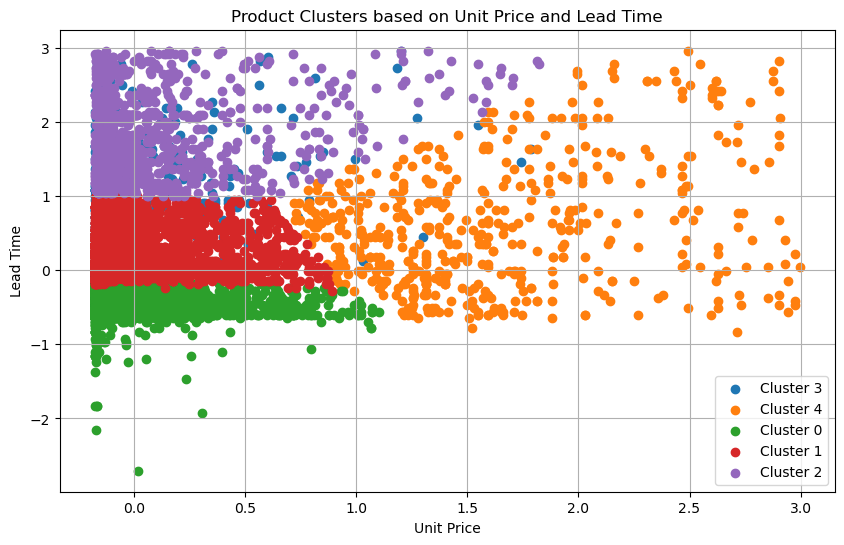

In [23]:
import matplotlib.pyplot as plt

# Scatter plot of the clusters
plt.figure(figsize=(10, 6))

# Iterate over unique cluster labels
for cluster_label in suppliers_kpis_df['Product_Cluster'].unique():
    cluster_data = suppliers_kpis_df[suppliers_kpis_df['Product_Cluster'] == cluster_label]
    plt.scatter(cluster_data['UNIT_PRICE'], cluster_data['LEAD TIME'], label=f'Cluster {cluster_label}')

# Adding labels and legend
plt.xlabel('Unit Price')
plt.ylabel('Lead Time')
plt.title('Product Clusters based on Unit Price and Lead Time')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

C:\Users\15146\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\15146\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\15146\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\15146\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

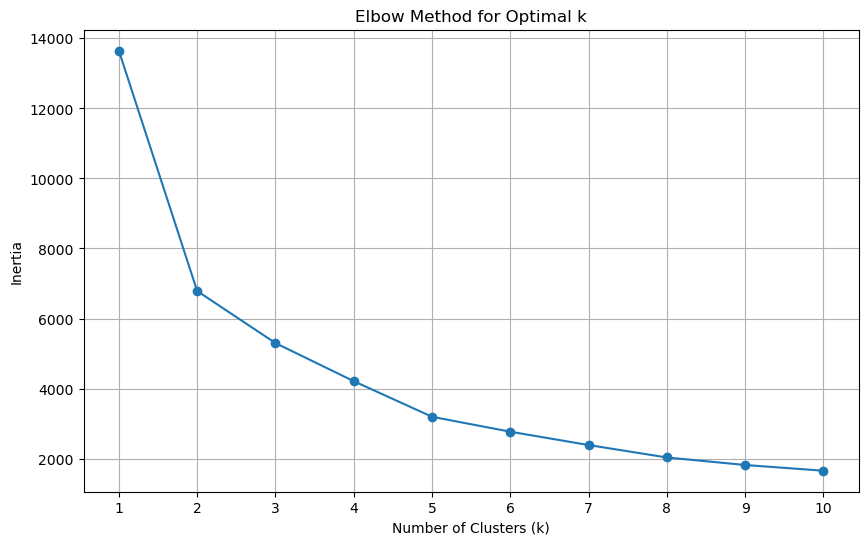

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Selecting features for clustering
product_features = suppliers_kpis_df[['UNIT_PRICE', 'LEAD TIME', 'BACKORDER_DAYS_LATE']]

# Define range of clusters to try
k_values = range(1, 11)  # Trying clusters from 1 to 10

# Initialize empty list to store inertia values
inertia_values = []

# Iterate over each k value and fit KMeans model
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(product_features)
    inertia_values.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [25]:
suppliers_kpis_df

,MOS_OLPHKEY,MOS_OLREFNO,PH_BUYER,PH_VNKEY,VN_NAME,MOS_IMKEY,IM_DESCR,RELEASE_DATE_PO,DUE_DATE,PROMISE_DATE,...,QTY_RECEIVED,OL_UNIT_R,UNIT_PRICE,PO_PRICE,Fiscal period,BACKORDER_DAYS_LATE,LEAD TIME,Late_or_Early_Arrival,Supplier_cluster,Product_Cluster
0,STE22520,2,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA060A,3/4 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,100,FT,-0.171313,517.40,2022-01-01,1.372302,0.446068,1.385741,1,3
1,STE22590,9,SPERRON,L175,LUMEN INC.,X21503L04,VARIATEUR 0.5HP-575V,2021-12-06,2022-01-11,2022-01-11,...,1,EA,0.921390,1131.39,2022-01-01,-0.195537,0.263426,-0.151251,1,4
2,DIM22843,1,DSOKOLOV,C650,13859380 CANADA INC.,NEA240A,"3"" TUYAU SS304L SCH 40",2021-12-22,2022-01-05,2022-01-05,...,240,FT,-0.143229,8188.56,2022-01-01,-0.195537,-0.284500,0.136935,1,0
3,DIM22761,6,DSOKOLOV,C103,C.F.F. SPECIALTY METALS INC.,NIA060A,"3/4"" TUYAU, SS316L,SCH 40.",2021-12-16,2022-01-20,2022-01-20,...,480,FT,-0.171190,2544.00,2022-01-01,-0.195537,-0.101858,-0.583530,1,1
4,STE22520,1,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA040A,1/2 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,200,FT,-0.171596,976.50,2022-01-01,1.372302,0.446068,1.385741,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21426,STE29501,1,SPERRON,K073,WAJAX LTEE.,EAU028A,O-RING 1.109DI X 0.139 NITRILE,2023-10-24,2023-11-01,2023-11-01,...,2,EA,-0.176274,0.12,2023-10-01,-0.195537,-0.604124,-0.103220,1,0
21427,ERI29479,5,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIQ600A,TOLE SS304L CR 20GA 2B+PLASTIC,2023-10-23,2023-10-25,2023-10-25,...,50447,LB,-0.174285,106443.17,2023-10-01,-0.195537,-0.558464,0.232997,1,0
21428,ERI29479,8,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIP050A,"PLAQUE HR 3/16, SS304L",2023-10-23,2023-10-25,2023-10-25,...,14401,LB,-0.174383,28946.01,2023-10-01,-0.195537,-0.558464,0.232997,1,0
21429,ERI29479,1,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIF075A,BARRE PLATE SS304L HR 1/8x1,2023-10-23,2023-10-25,2023-10-25,...,279,LB,-0.173470,902.70,2023-10-01,-0.195537,-0.558464,0.232997,1,0


In [26]:
# Define a dictionary to map cluster labels to ranks
cluster_rank_mapping = {4: 3, 3: 4, 0: 5, 1: 1, 2: 2}

# Create a new column for supplier rank based on the first cluster column
suppliers_kpis_df['Supplier_Rank'] = suppliers_kpis_df['Supplier_cluster'].map(cluster_rank_mapping)

# Display the DataFrame with the new column
print("DataFrame with Supplier Ranks:")
suppliers_kpis_df

DataFrame with Supplier Ranks:


,MOS_OLPHKEY,MOS_OLREFNO,PH_BUYER,PH_VNKEY,VN_NAME,MOS_IMKEY,IM_DESCR,RELEASE_DATE_PO,DUE_DATE,PROMISE_DATE,...,OL_UNIT_R,UNIT_PRICE,PO_PRICE,Fiscal period,BACKORDER_DAYS_LATE,LEAD TIME,Late_or_Early_Arrival,Supplier_cluster,Product_Cluster,Supplier_Rank
0,STE22520,2,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA060A,3/4 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,FT,-0.171313,517.40,2022-01-01,1.372302,0.446068,1.385741,1,3,1
1,STE22590,9,SPERRON,L175,LUMEN INC.,X21503L04,VARIATEUR 0.5HP-575V,2021-12-06,2022-01-11,2022-01-11,...,EA,0.921390,1131.39,2022-01-01,-0.195537,0.263426,-0.151251,1,4,1
2,DIM22843,1,DSOKOLOV,C650,13859380 CANADA INC.,NEA240A,"3"" TUYAU SS304L SCH 40",2021-12-22,2022-01-05,2022-01-05,...,FT,-0.143229,8188.56,2022-01-01,-0.195537,-0.284500,0.136935,1,0,1
3,DIM22761,6,DSOKOLOV,C103,C.F.F. SPECIALTY METALS INC.,NIA060A,"3/4"" TUYAU, SS316L,SCH 40.",2021-12-16,2022-01-20,2022-01-20,...,FT,-0.171190,2544.00,2022-01-01,-0.195537,-0.101858,-0.583530,1,1,1
4,STE22520,1,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA040A,1/2 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,FT,-0.171596,976.50,2022-01-01,1.372302,0.446068,1.385741,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21426,STE29501,1,SPERRON,K073,WAJAX LTEE.,EAU028A,O-RING 1.109DI X 0.139 NITRILE,2023-10-24,2023-11-01,2023-11-01,...,EA,-0.176274,0.12,2023-10-01,-0.195537,-0.604124,-0.103220,1,0,1
21427,ERI29479,5,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIQ600A,TOLE SS304L CR 20GA 2B+PLASTIC,2023-10-23,2023-10-25,2023-10-25,...,LB,-0.174285,106443.17,2023-10-01,-0.195537,-0.558464,0.232997,1,0,1
21428,ERI29479,8,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIP050A,"PLAQUE HR 3/16, SS304L",2023-10-23,2023-10-25,2023-10-25,...,LB,-0.174383,28946.01,2023-10-01,-0.195537,-0.558464,0.232997,1,0,1
21429,ERI29479,1,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIF075A,BARRE PLATE SS304L HR 1/8x1,2023-10-23,2023-10-25,2023-10-25,...,LB,-0.173470,902.70,2023-10-01,-0.195537,-0.558464,0.232997,1,0,1


In [27]:
# Define a dictionary to map product cluster labels to ranks
product_cluster_rank_mapping = {1: 3, 4: 5, 2: 5, 0: 1, 3: 4}

# Create a new column for product cluster rank
suppliers_kpis_df['Product_Cluster_Rank'] = suppliers_kpis_df['Product_Cluster'].map(product_cluster_rank_mapping)

# Display the DataFrame with the new column
print("DataFrame with Product Cluster Ranks:")
suppliers_kpis_df


DataFrame with Product Cluster Ranks:


,MOS_OLPHKEY,MOS_OLREFNO,PH_BUYER,PH_VNKEY,VN_NAME,MOS_IMKEY,IM_DESCR,RELEASE_DATE_PO,DUE_DATE,PROMISE_DATE,...,UNIT_PRICE,PO_PRICE,Fiscal period,BACKORDER_DAYS_LATE,LEAD TIME,Late_or_Early_Arrival,Supplier_cluster,Product_Cluster,Supplier_Rank,Product_Cluster_Rank
0,STE22520,2,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA060A,3/4 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,-0.171313,517.40,2022-01-01,1.372302,0.446068,1.385741,1,3,1,4
1,STE22590,9,SPERRON,L175,LUMEN INC.,X21503L04,VARIATEUR 0.5HP-575V,2021-12-06,2022-01-11,2022-01-11,...,0.921390,1131.39,2022-01-01,-0.195537,0.263426,-0.151251,1,4,1,5
2,DIM22843,1,DSOKOLOV,C650,13859380 CANADA INC.,NEA240A,"3"" TUYAU SS304L SCH 40",2021-12-22,2022-01-05,2022-01-05,...,-0.143229,8188.56,2022-01-01,-0.195537,-0.284500,0.136935,1,0,1,1
3,DIM22761,6,DSOKOLOV,C103,C.F.F. SPECIALTY METALS INC.,NIA060A,"3/4"" TUYAU, SS316L,SCH 40.",2021-12-16,2022-01-20,2022-01-20,...,-0.171190,2544.00,2022-01-01,-0.195537,-0.101858,-0.583530,1,1,1,3
4,STE22520,1,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA040A,1/2 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,-0.171596,976.50,2022-01-01,1.372302,0.446068,1.385741,1,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21426,STE29501,1,SPERRON,K073,WAJAX LTEE.,EAU028A,O-RING 1.109DI X 0.139 NITRILE,2023-10-24,2023-11-01,2023-11-01,...,-0.176274,0.12,2023-10-01,-0.195537,-0.604124,-0.103220,1,0,1,1
21427,ERI29479,5,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIQ600A,TOLE SS304L CR 20GA 2B+PLASTIC,2023-10-23,2023-10-25,2023-10-25,...,-0.174285,106443.17,2023-10-01,-0.195537,-0.558464,0.232997,1,0,1,1
21428,ERI29479,8,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIP050A,"PLAQUE HR 3/16, SS304L",2023-10-23,2023-10-25,2023-10-25,...,-0.174383,28946.01,2023-10-01,-0.195537,-0.558464,0.232997,1,0,1,1
21429,ERI29479,1,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIF075A,BARRE PLATE SS304L HR 1/8x1,2023-10-23,2023-10-25,2023-10-25,...,-0.173470,902.70,2023-10-01,-0.195537,-0.558464,0.232997,1,0,1,1


In [28]:
# Function to calculate follow-up dates
def calculate_follow_up(row):
    lead_time = row['LEAD TIME']
    duo_date = row['DUE_DATE']
    start_date = row['RELEASE_DATE_PO']  # Assuming 'RELEASE_DATE_PO' is the start date column
    supplier_rank = row['Supplier_Rank']
    product_rank = row['Product_Cluster_Rank']
    rank_sum = supplier_rank + product_rank

    if pd.isna(lead_time):  # Check if lead time is NaN
        lead_time = (duo_date - start_date).days  # Calculate lead time from due date and start date

    if (supplier_rank == 5 or product_rank == 5):
        first_follow_up = duo_date - pd.Timedelta(days=lead_time * 0.5)  # 50% of lead time
        second_follow_up = duo_date - pd.Timedelta(days=lead_time * 0.75)  # 75% of lead time
        third_follow_up = duo_date
    elif (supplier_rank == 4 or product_rank == 4) and rank_sum > 7:
        first_follow_up = duo_date - pd.Timedelta(days=lead_time * 0.5)  # 50% of lead time
        second_follow_up = duo_date - pd.Timedelta(days=lead_time * 0.75)  # 75% of lead time
        third_follow_up = duo_date
    elif (supplier_rank == 4 or product_rank == 4) and rank_sum <= 7:
        first_follow_up = duo_date - pd.Timedelta(days=lead_time * 0.75)  # 75% of lead time
        second_follow_up = duo_date
        third_follow_up = None
    elif (supplier_rank == 3 or product_rank == 3) or (supplier_rank == 2 or product_rank == 2):
        first_follow_up = duo_date - pd.Timedelta(days=lead_time * 0.75)  # 75% of lead time
        second_follow_up = duo_date
        third_follow_up = None
    elif supplier_rank == 1 and product_rank == 1:
        first_follow_up = duo_date - pd.Timedelta(days=1)  # One day before due date
        second_follow_up = duo_date - pd.Timedelta(days=1)  # One day before due date
        third_follow_up = None
    else:
        first_follow_up = duo_date - pd.Timedelta(days=lead_time * 0.75)  # 75% of lead time
        second_follow_up = duo_date
        third_follow_up = None

    return pd.Series([first_follow_up, second_follow_up, third_follow_up])

# Apply the function to create new columns
suppliers_kpis_df[['First_Follow_Up', 'Second_Follow_Up', 'Third_Follow_Up']] = suppliers_kpis_df.apply(calculate_follow_up, axis=1)

# Display the DataFrame with the new columns
print("DataFrame with Follow-up Dates:")
suppliers_kpis_df

DataFrame with Follow-up Dates:


,MOS_OLPHKEY,MOS_OLREFNO,PH_BUYER,PH_VNKEY,VN_NAME,MOS_IMKEY,IM_DESCR,RELEASE_DATE_PO,DUE_DATE,PROMISE_DATE,...,BACKORDER_DAYS_LATE,LEAD TIME,Late_or_Early_Arrival,Supplier_cluster,Product_Cluster,Supplier_Rank,Product_Cluster_Rank,First_Follow_Up,Second_Follow_Up,Third_Follow_Up
0,STE22520,2,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA060A,3/4 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,1.372302,0.446068,1.385741,1,3,1,4,2022-01-04 15:58:14.788843555,2022-01-05 00:00:00.000000000,NaT
1,STE22590,9,SPERRON,L175,LUMEN INC.,X21503L04,VARIATEUR 0.5HP-575V,2021-12-06,2022-01-11,2022-01-11,...,-0.195537,0.263426,-0.151251,1,4,1,5,2022-01-10 20:50:19.998387310,2022-01-10 19:15:29.997580964,2022-01-11
2,DIM22843,1,DSOKOLOV,C650,13859380 CANADA INC.,NEA240A,"3"" TUYAU SS304L SCH 40",2021-12-22,2022-01-05,2022-01-05,...,-0.195537,-0.284500,0.136935,1,0,1,1,2022-01-04 00:00:00.000000000,2022-01-04 00:00:00.000000000,NaT
3,DIM22761,6,DSOKOLOV,C103,C.F.F. SPECIALTY METALS INC.,NIA060A,"3/4"" TUYAU, SS316L,SCH 40.",2021-12-16,2022-01-20,2022-01-20,...,-0.195537,-0.101858,-0.583530,1,1,1,3,2022-01-20 01:50:00.415055783,2022-01-20 00:00:00.000000000,NaT
4,STE22520,1,SPERRON,G194,GUILLEVIN INTERNATIONAL INC.,RDA040A,1/2 TUYAU RIGID,2021-11-30,2022-01-05,2021-12-10,...,1.372302,0.446068,1.385741,1,3,1,4,2022-01-04 15:58:14.788843555,2022-01-05 00:00:00.000000000,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21426,STE29501,1,SPERRON,K073,WAJAX LTEE.,EAU028A,O-RING 1.109DI X 0.139 NITRILE,2023-10-24,2023-11-01,2023-11-01,...,-0.195537,-0.604124,-0.103220,1,0,1,1,2023-10-31 00:00:00.000000000,2023-10-31 00:00:00.000000000,NaT
21427,ERI29479,5,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIQ600A,TOLE SS304L CR 20GA 2B+PLASTIC,2023-10-23,2023-10-25,2023-10-25,...,-0.195537,-0.558464,0.232997,1,0,1,1,2023-10-24 00:00:00.000000000,2023-10-24 00:00:00.000000000,NaT
21428,ERI29479,8,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIP050A,"PLAQUE HR 3/16, SS304L",2023-10-23,2023-10-25,2023-10-25,...,-0.195537,-0.558464,0.232997,1,0,1,1,2023-10-24 00:00:00.000000000,2023-10-24 00:00:00.000000000,NaT
21429,ERI29479,1,ELAGUNA,D180,DIVERSIFIED ULBRICH,AIF075A,BARRE PLATE SS304L HR 1/8x1,2023-10-23,2023-10-25,2023-10-25,...,-0.195537,-0.558464,0.232997,1,0,1,1,2023-10-24 00:00:00.000000000,2023-10-24 00:00:00.000000000,NaT


In [29]:
from datetime import datetime

# Get today's date
today_date = datetime.today().date()

# Filter products where today's date matches any of the follow-up dates
follow_up_today = suppliers_kpis_df[
    (suppliers_kpis_df['First_Follow_Up'].dt.date == today_date) |
    (suppliers_kpis_df['Second_Follow_Up'].dt.date == today_date) |
    (suppliers_kpis_df['Third_Follow_Up'].dt.date == today_date)
]

# Select relevant columns
follow_up_today = follow_up_today[['IM_DESCR', 'VN_NAME', 'RELEASE_DATE_PO', 'DUE_DATE', 'First_Follow_Up', 'Second_Follow_Up', 'Third_Follow_Up']]

# Display the list of products to follow up today
print("Products to follow up today:")
print(follow_up_today)


Products to follow up today:
Empty DataFrame
Columns: [IM_DESCR, VN_NAME, RELEASE_DATE_PO, DUE_DATE, First_Follow_Up, Second_Follow_Up, Third_Follow_Up]
Index: []


In [30]:
import pandas as pd
from datetime import datetime

# Create a sample DataFrame with product information
data = {
    'IM_DESCR': ['Product A', 'Product B', 'Product C'],
    'VN_NAME': ['Supplier X', 'Supplier Y', 'Supplier Z'],
    'RELEASE_DATE_PO': [datetime(2024, 3, 20), datetime(2024, 3, 15), datetime(2024, 3, 10)],
    'DUE_DATE': [datetime(2024, 4, 5), datetime(2024, 4, 10), datetime(2024, 4, 15)],
    'First_Follow_Up': [datetime(2024, 4, 1), datetime(2024, 4, 5), datetime(2024, 4, 10)],
    'Second_Follow_Up': [datetime(2024, 6, 9), datetime(2024, 6, 9), None],
    'Third_Follow_Up': [datetime(2024, 4, 5), None, None]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the sample DataFrame
print("Sample DataFrame:")
print(df)
print()

# Get today's date
today_date = datetime(2024, 6, 9).date()  # Simulate today's date as June 9, 2024

# Filter products where today's date matches any of the follow-up dates
follow_up_today = df[
    (df['First_Follow_Up'].dt.date == today_date) |
    (df['Second_Follow_Up'].dt.date == today_date) |
    (df['Third_Follow_Up'].dt.date == today_date)
]

# Select relevant columns
follow_up_today = follow_up_today[['IM_DESCR', 'VN_NAME', 'RELEASE_DATE_PO', 'DUE_DATE', 'First_Follow_Up', 'Second_Follow_Up', 'Third_Follow_Up']]

# Display the list of products to follow up today
print("Products to follow up today:")
print(follow_up_today)


Sample DataFrame:
    IM_DESCR     VN_NAME RELEASE_DATE_PO   DUE_DATE First_Follow_Up  \
0  Product A  Supplier X      2024-03-20 2024-04-05      2024-04-01   
1  Product B  Supplier Y      2024-03-15 2024-04-10      2024-04-05   
2  Product C  Supplier Z      2024-03-10 2024-04-15      2024-04-10   

  Second_Follow_Up Third_Follow_Up  
0       2024-06-09      2024-04-05  
1       2024-06-09             NaT  
2              NaT             NaT  

Products to follow up today:
    IM_DESCR     VN_NAME RELEASE_DATE_PO   DUE_DATE First_Follow_Up  \
0  Product A  Supplier X      2024-03-20 2024-04-05      2024-04-01   
1  Product B  Supplier Y      2024-03-15 2024-04-10      2024-04-05   

  Second_Follow_Up Third_Follow_Up  
0       2024-06-09      2024-04-05  
1       2024-06-09             NaT  
